<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_viGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# For github continuous integration only
# Please ignore if you're running this notebook!
import os
if os.environ.get("CI_SMOKE"):
    SMOKE = True
else:
    SMOKE = False

# Sparse image reconstruction with GPax


*Prepared by Maxim Ziatdinov (May 2023). Last updated in October 2023.*

This notebook shows a simple example of how GPax can be utilized for sparse image reconstruction.

## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version).

In [ ]:
!pip install gpax

Import needed packages:

In [2]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Enable some pretty plotting.

In [4]:
import matplotlib as mpl

In [5]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

# Sparse image reconstruction

Download sparse image data. This is a scanning probe microsocpy image obtained via a sparse spiral scanning. See [this paper](https://doi.org/10.1002/smll.202002878) for more details.

In [6]:
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'

Visualize data:

In [ ]:
imgdata = np.load('spiral_scans_2d.npy')

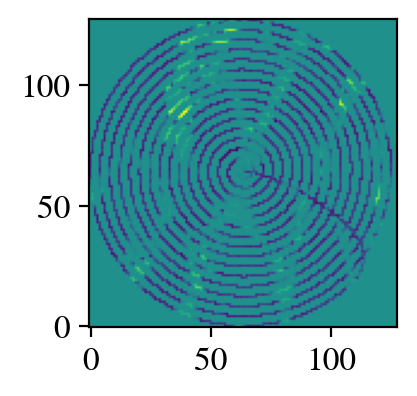

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(imgdata, origin='lower')
plt.show()

Normalize and assign zeros to regions with missing data values:

In [9]:
sparse_img = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
sparse_img[sparse_img == sparse_img[1, 1]] = 0 # Take value at [1, 1] as missing data value

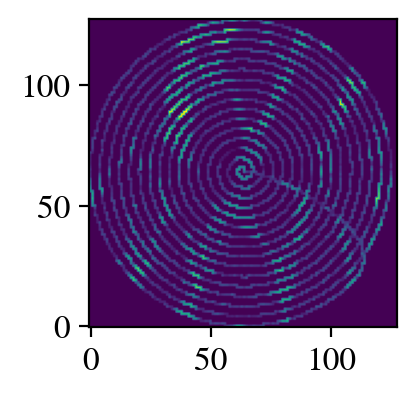

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(sparse_img, origin='lower')
plt.show()

Next, we prepare training inputs/targets for GP. Note that the missing data values must be represented by zeros. If you have actual data with elements whose values are zero, you will need to re-normalize it accordingly. Otherwise, those elements will be interpreted as mising values.

In [13]:
X_train, y_train, X_full = gpax.utils.preprocess_sparse_image(sparse_img)

Initilaize and train a variational inference GP model:

In [16]:
key1, key2 = gpax.utils.get_keys()

gp_model = gpax.viGP(input_dim=2, kernel='Matern', guide='delta')
gp_model.fit(key1, X_train, y_train, num_steps=250 if not SMOKE else 20, step_size=0.05)

100%|█| 250/250 [04:30<00:00,  1.08s/it, init loss: 5613.0815, avg. loss [229-24


Inferred GP parameters
k_length         [4.2311997 3.2698   ]
k_scale          0.051999997
noise            0.0019999999


Use the trained to reconstruct the entire image (i.e., predict pixel values for a full set of pixel indices):

In [18]:
y_pred, y_var = gp_model.predict(key2, X_full, noiseless=True)

Plot the results:

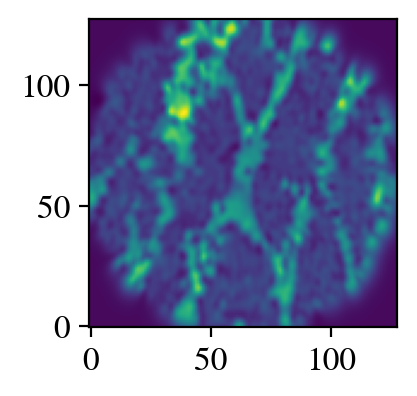

In [19]:
y_pred = y_pred.reshape(128, 128) # (height, width) of the original image

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(y_pred, origin='lower')
plt.show()